<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Cecilie/AML_IceCores_last_layer_umap_and_confusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
from Models import make_autoencoder, make_NN
! gdown --id 1vmtn2HUFFspLehTO-9HNCnphSdiZGez3
! gdown --id 1vOWLDeQh2EEyH2J3VH5XZHhTLqMqAjkV
! gdown --id 1fv_xxclDQrccHZ-T00-cVYHIMFaYjklA
! gdown --id 1NATGxPWVYS71Y-dwPZQvrE7BdsoSpVP8
! unzip autoencoder_128.zip
! unzip encoder_128.zip
! unzip NN_scalar_encoder_128.zip
! unzip NN_last_layer_scalar_encoder_128.zip
!pip install pyyaml h5py 
!pip install umap-learn
!pip install bayesian-optimization

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
from sklearn.metrics import confusion_matrix

In [3]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
train_df, test_df = train_test_split(sup_df, test_size=0.2, random_state=37)
train = training_set(train_df, sup_im_path)
test = training_set(test_df, sup_im_path)

In [4]:
# save image_size
im_e, _, _ = train.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [5]:
train_size = len(train.labels)
test_size = len(test.labels)

In [6]:
encoder = keras.models.load_model('encoder_128')

In [7]:
increment = 5000
nr_its = train_size//increment
points_left_over = train_size % increment

x_train_ims = []
x_train_lab = []
x_train_feats = []
image_count = 0
for i in range(nr_its):
  x_train = []
  for j in range(increment):
      im, lab, feat = train.__getitem__(image_count)
      image_count += 1
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)

  encoded = encoder.predict(x_train)

  x_train_ims.extend(encoded)

x_train = []
for i in range(points_left_over):
  im, lab, feat = train.__getitem__(image_count)
  image_count += 1
  x_train.append(im)
  x_train_lab.append(lab)
  x_train_feats.append(feat)
x_train = np.array(x_train)

encoded = encoder.predict(x_train)

x_train_ims.extend(encoded)

x_train_ims = np.array(x_train_ims)
x_train_feats = np.array(x_train_feats)

x_train = []
for i in range(len(x_train_ims)):
  one = np.append(x_train_feats[i], x_train_ims[i])
  x_train.append(one)

x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)

In [8]:
increment = 5000
nr_its = test_size//increment
points_left_over = test_size % increment

x_test_ims = []
x_test_lab = []
x_test_feats = []
image_count = 0
for i in range(nr_its):
  x_test = []
  for j in range(increment):
      im, lab, feat = test.__getitem__(image_count)
      image_count += 1
      x_test.append(im)
      x_test_lab.append(lab)
      x_test_feats.append(feat)
  x_test = np.array(x_test)

  encoded = encoder.predict(x_test)

  x_test_ims.extend(encoded)

x_test = []
for i in range(points_left_over):
  im, lab, feat = test.__getitem__(image_count)
  image_count += 1
  x_test.append(im)
  x_test_lab.append(lab)
  x_test_feats.append(feat)
x_test = np.array(x_test)

encoded = encoder.predict(x_test)

x_test_ims.extend(encoded)

x_test_ims = np.array(x_test_ims)
x_test_feats = np.array(x_test_feats)

x_test = []
for i in range(len(x_test_ims)):
  one = np.append(x_test_feats[i], x_test_ims[i])
  x_test.append(one)

x_test = np.array(x_test)
x_test_lab = np.array(x_test_lab)

In [9]:
nn_feats, nn_feats_last_layer = make_NN(input_length=len(x_train_feats[0]))
nn_ims, nn_ims_last_layer = make_NN(input_length=len(x_train_ims[0]))
nn_all, nn_all_last_layer = make_NN(input_length=len(x_train[0]))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)

nn_feats.fit(x_train_feats, x_train_lab, batch_size=32, epochs=200, validation_split=0.1, callbacks=[callback])
nn_ims.fit(x_train_ims, x_train_lab, batch_size=32, epochs=200, validation_split=0.1, callbacks=[callback])
nn_all.fit(x_train, x_train_lab, batch_size=32, epochs=200, validation_split=0.1, callbacks=[callback])

Epoch 1/200
3330/3330 [==============================] - 25s 7ms/step - loss: 0.6402 - accuracy: 0.7686 - val_loss: 0.5223 - val_accuracy: 0.8076
Epoch 2/200
3330/3330 [==============================] - 21s 6ms/step - loss: 0.5329 - accuracy: 0.8056 - val_loss: 0.4589 - val_accuracy: 0.8305
Epoch 3/200
3330/3330 [==============================] - 21s 6ms/step - loss: 0.5075 - accuracy: 0.8154 - val_loss: 0.4621 - val_accuracy: 0.8294
Epoch 4/200
3330/3330 [==============================] - 22s 7ms/step - loss: 0.4883 - accuracy: 0.8226 - val_loss: 0.4985 - val_accuracy: 0.8091
Epoch 5/200
3330/3330 [==============================] - 21s 6ms/step - loss: 0.4738 - accuracy: 0.8276 - val_loss: 0.4297 - val_accuracy: 0.8475
Epoch 6/200
3330/3330 [==============================] - 21s 6ms/step - loss: 0.4622 - accuracy: 0.8309 - val_loss: 0.4278 - val_accuracy: 0.8448
Epoch 7/200
3330/3330 [==============================] - 21s 6ms/step - loss: 0.4551 - accuracy: 0.8338 - val_loss: 0.4468 -

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


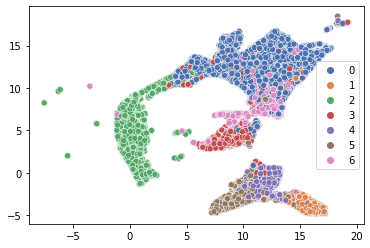

In [11]:
last_hidden_vals = nn_feats_last_layer.predict(x_test_feats)
map = umap.UMAP(n_components=2)#, n_neighbors=8, min_dist=0.1)
y = map.fit_transform(last_hidden_vals)

plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_test_lab, palette='deep')
#plt.show()
plt.savefig('last_hidden_nn_feats.png')

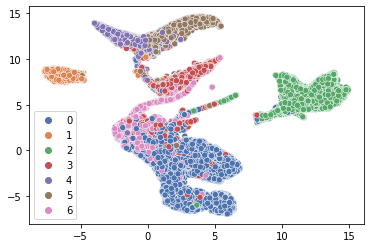

In [12]:
last_hidden_vals = nn_ims_last_layer.predict(x_test_ims)
map = umap.UMAP(n_components=2)#, n_neighbors=8, min_dist=0.1)
y = map.fit_transform(last_hidden_vals)

plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_test_lab, palette='deep')
#plt.show()
plt.savefig('last_hidden_nn_ims.png')

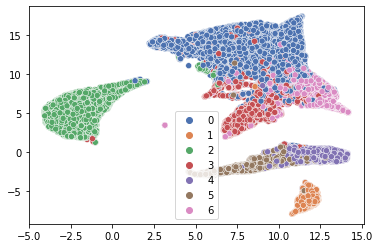

In [13]:
last_hidden_vals = nn_all_last_layer.predict(x_test)
map = umap.UMAP(n_components=2)#, n_neighbors=8, min_dist=0.1)
y = map.fit_transform(last_hidden_vals)

plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_test_lab, palette='deep')
#plt.show()
plt.savefig('last_hidden_nn_all.png')

In [14]:
x_test_3 = np.copy(x_test_lab)
x_test_3[x_test_lab==0] = 0
x_test_3[x_test_lab==3] = 0
x_test_3[x_test_lab==6] = 0
x_test_3[x_test_lab==1] = 1
x_test_3[x_test_lab==4] = 1
x_test_3[x_test_lab==5] = 1
x_test_3[x_test_lab==2] = 2
x_test_3

array([0, 2, 0, ..., 0, 0, 2])

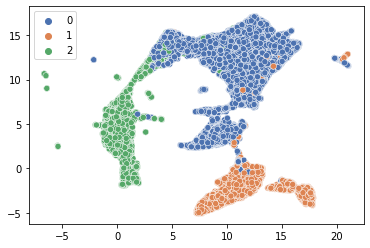

In [15]:
last_hidden_vals = nn_feats_last_layer.predict(x_test_feats)
map = umap.UMAP(n_components=2)#, n_neighbors=8, min_dist=0.1)
y = map.fit_transform(last_hidden_vals)

plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_test_3, palette='deep')
#plt.show()
plt.savefig('last_hidden_nn_feats_3.png')

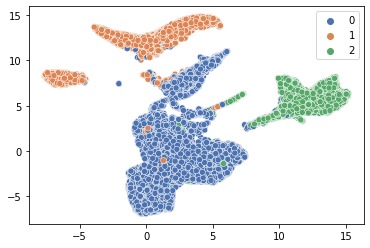

In [16]:
last_hidden_vals = nn_ims_last_layer.predict(x_test_ims)
map = umap.UMAP(n_components=2)#, n_neighbors=8, min_dist=0.1)
y = map.fit_transform(last_hidden_vals)

plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_test_3, palette='deep')
#plt.show()
plt.savefig('last_hidden_nn_ims_3.png')

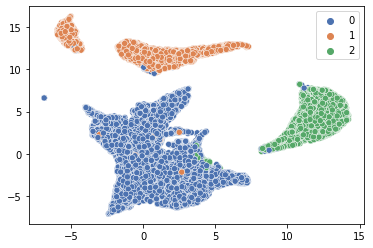

In [17]:
last_hidden_vals = nn_all_last_layer.predict(x_test)
map = umap.UMAP(n_components=2)#, n_neighbors=8, min_dist=0.1)
y = map.fit_transform(last_hidden_vals)

plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_test_3, palette='deep')
#plt.show()
plt.savefig('last_hidden_nn_all_3.png')

In [18]:
preds_feats = np.argmax(nn_feats.predict(x_test_feats),axis=1)
print(sum(preds_feats==x_test_lab)/len(x_test_lab))

preds_ims = np.argmax(nn_ims.predict(x_test_ims),axis=1)
print(sum(preds_ims==x_test_lab)/len(x_test_lab))

preds_all = np.argmax(nn_all.predict(x_test),axis=1)
print(sum(preds_all==x_test_lab)/len(x_test_lab))

0.8603676669370101
0.8722965666396323
0.8904095701540957


In [19]:
cm_feats = confusion_matrix(x_test_lab, preds_feats)
cm_feats_perc = cm_feats/np.sum(cm_feats)

cm_ims = confusion_matrix(x_test_lab, preds_ims)
cm_ims_perc = cm_ims/np.sum(cm_ims)

cm_all = confusion_matrix(x_test_lab, preds_all)
cm_all_perc = cm_all/np.sum(cm_all)

In [20]:
types = ['camp', 'corylus', 'dust', 'grim', 'qrob', 'qsub', 'cont']

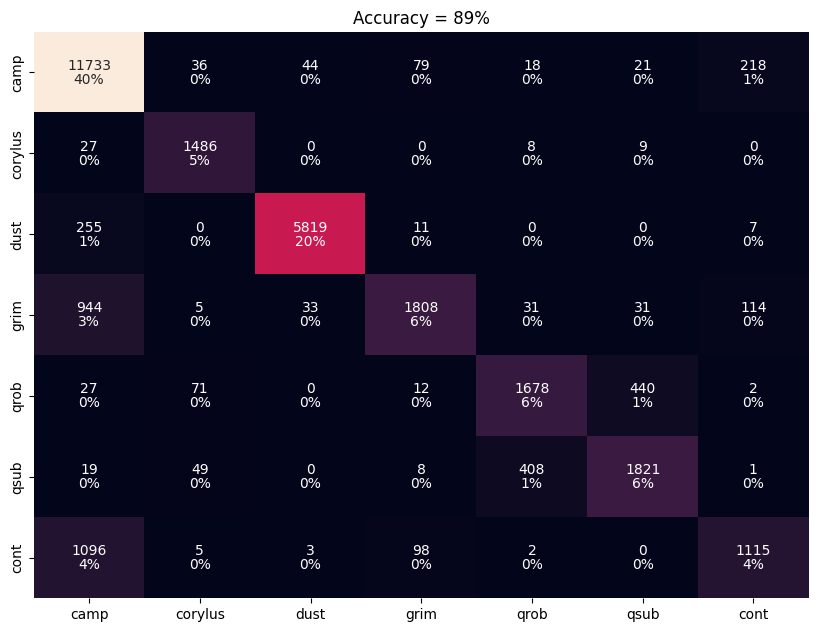

In [21]:
plt.figure(figsize=(10,7.5),dpi=100)
plt.title('Accuracy = 89%')
sb.heatmap(cm_feats, annot=False, cbar=False, xticklabels=types, yticklabels=types)
sb.heatmap(cm_feats, annot=True, annot_kws={'va':'bottom'}, fmt="", cbar=False, xticklabels=types, yticklabels=types)
sb.heatmap(cm_feats, annot=cm_feats_perc, annot_kws={'va':'top'}, fmt=".0%", cbar=False, xticklabels=types, yticklabels=types)
plt.savefig('confusion_feats.png')

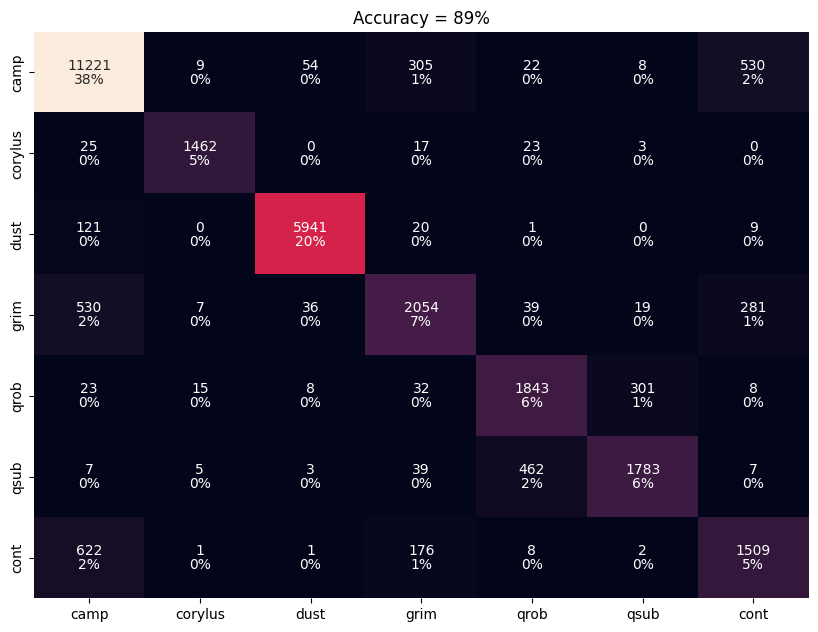

In [22]:
plt.figure(figsize=(10,7.5),dpi=100)
plt.title('Accuracy = 89%')
sb.heatmap(cm_ims, annot=False, cbar=False, xticklabels=types, yticklabels=types)
sb.heatmap(cm_ims, annot=True, annot_kws={'va':'bottom'}, fmt="", cbar=False, xticklabels=types, yticklabels=types)
sb.heatmap(cm_ims, annot=cm_ims_perc, annot_kws={'va':'top'}, fmt=".0%", cbar=False, xticklabels=types, yticklabels=types)
plt.savefig('confusion_ims.png')

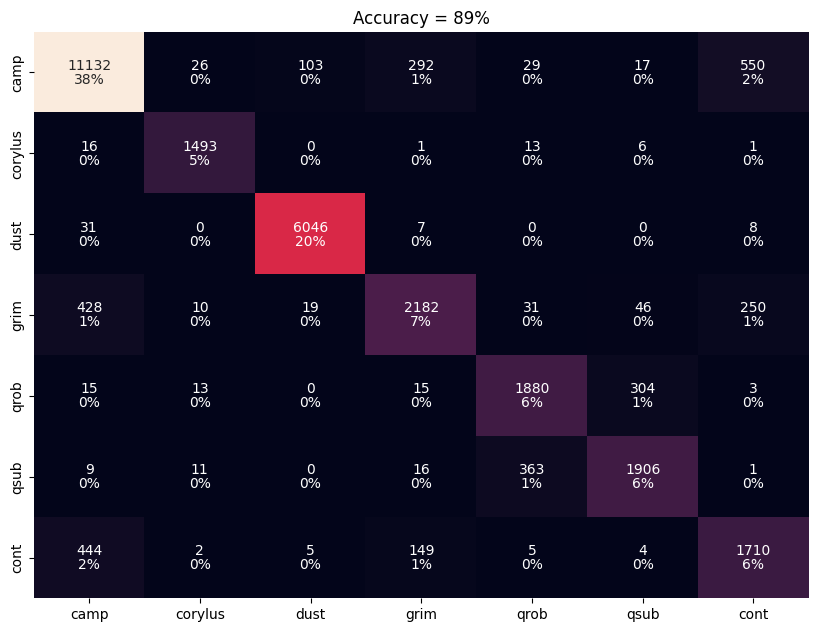

In [23]:
plt.figure(figsize=(10,7.5),dpi=100)
plt.title('Accuracy = 89%')
sb.heatmap(cm_all, annot=False, cbar=False, xticklabels=types, yticklabels=types)
sb.heatmap(cm_all, annot=True, annot_kws={'va':'bottom'}, fmt="", cbar=False, xticklabels=types, yticklabels=types)
sb.heatmap(cm_all, annot=cm_all_perc, annot_kws={'va':'top'}, fmt=".0%", cbar=False, xticklabels=types, yticklabels=types)
plt.savefig('confusion_all.png')

In [ ]:
x_test.shape

(29592, 162)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


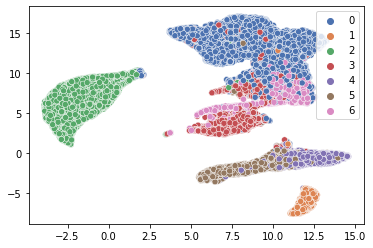

In [ ]:
last_hidden_vals = NN_last_layer.predict(x_test)
map = umap.UMAP(n_components=2)#, n_neighbors=8, min_dist=0.1)
y = map.fit_transform(last_hidden_vals)

plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_test_lab, palette='deep')
#plt.show()
plt.savefig('last_hidden_nn_all_dat.png')

In [ ]:
x_test_3 = np.copy(x_test_lab)
x_test_3[x_test_lab==0] = 0
x_test_3[x_test_lab==3] = 0
x_test_3[x_test_lab==6] = 0
x_test_3[x_test_lab==1] = 1
x_test_3[x_test_lab==4] = 1
x_test_3[x_test_lab==5] = 1
x_test_3[x_test_lab==2] = 2
x_test_3

array([0, 2, 0, ..., 0, 0, 2])

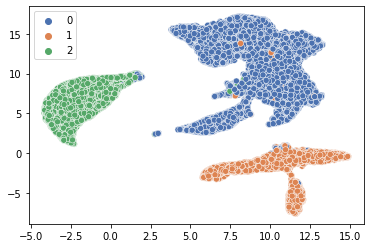

In [ ]:
last_hidden_vals = NN_last_layer.predict(x_test)
map = umap.UMAP(n_components=2)#, n_neighbors=8, min_dist=0.1)
y = map.fit_transform(last_hidden_vals)

plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_test_3, palette='deep')
#plt.show()
plt.savefig('last_hidden_nn_all_dat_3.png')

In [ ]:
preds = NN.predict(x_test)


In [ ]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
sup = training_set(sup_df, sup_im_path)

In [ ]:
# save image_size
im_e, _, _ = sup.__getitem__(0)
image_size = im_e.shape[0]
image_size

In [ ]:
# create encoder training
nr_tot_images = len(sup.labels)
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
rand_idx = np.arange(0,nr_tot_images)
rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
for i in range(nr_ims):
    im, lab, feat = sup.__getitem__(rand_idx[i])
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

In [ ]:
y_preds = encoder.predict(x_train)

In [ ]:
x_train_with_encoded = []
for i in range(len(y_preds)):
    inp = np.append(x_train_feats[i], y_preds[i])
    x_train_with_encoded.append(inp)
x_train_with_encoded = np.array(x_train_with_encoded)

In [ ]:
nn_feats, _ = make_NN(input_length=len(x_train_feats[0]))
nn_ims, _ = make_NN(input_length=len(y_preds[0]))
#nn_all, _ = make_NN(input_length=len(x_train_with_encoded[0])))